# Jacobian Classification Visualization

This notebook analyzes the separation between Memorized and Unmemorized prompts based on Conditional Jacobian Norms.
It performs analysis at two levels:
1. **Sample Level**: Using all individual noise samples (100 per prompt).
2. **Prompt Level**: Averaging the Jacobian Norms over the 100 samples for each prompt.

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set Style
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 14})

In [2]:
# Load Data
base_dir = "/home/gpuadmin/cssin/init_noise_diffusion_memorization/results/jacobian_classification_diff_timestep_proj_1_seed_36/t_idx_0"
csv_path = os.path.join(base_dir, "jacobian_norms_results.csv")

if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV file not found at {csv_path}")

df_results = pd.read_csv(csv_path)
print(f"Loaded {len(df_results)} samples.")
df_results.head()

Loaded 2000 samples.


,Group,Prompt_Idx,Sample_Idx,JacobianNorm,Caption,TimeTaken
0,Memorized,0,0,53.836346,Emma Watson to play Belle in Disney's <i>Beaut...,6.467912
1,Memorized,0,1,42.203922,Emma Watson to play Belle in Disney's <i>Beaut...,6.467912
2,Memorized,0,2,39.970798,Emma Watson to play Belle in Disney's <i>Beaut...,6.467912
3,Memorized,0,3,41.787094,Emma Watson to play Belle in Disney's <i>Beaut...,6.467912
4,Memorized,0,4,42.850357,Emma Watson to play Belle in Disney's <i>Beaut...,6.467912


In [3]:
def calculate_optimal_threshold(df, val_col="JacobianNorm", group_col="Group", pos_label="Memorized"):
    """
    Calculates the optimal threshold to separate two groups.
    Returns threshold, accuracy, direction, and error stats.
    """
    df_sorted = df.sort_values(by=val_col).reset_index(drop=True)
    y_true = (df_sorted[group_col] == pos_label).astype(int).values
    values = df_sorted[val_col].values
    
    n_total = len(y_true)
    n_pos = np.sum(y_true)
    n_neg = n_total - n_pos
    
    cum_pos = np.cumsum(y_true)
    cum_neg = np.cumsum(1 - y_true)
    
    # Case A: Pos > Threshold
    # Correct = (Neg below T) + (Pos above T)
    #         = cum_neg + (n_pos - cum_pos)
    acc_A = (cum_neg + (n_pos - cum_pos)) / n_total
    
    # Case B: Pos < Threshold
    # Correct = (Pos below T) + (Neg above T)
    #         = cum_pos + (n_neg - cum_neg)
    acc_B = (cum_pos + (n_neg - cum_neg)) / n_total
    
    idx_A = np.argmax(acc_A)
    idx_B = np.argmax(acc_B)
    
    if acc_A[idx_A] >= acc_B[idx_B]:
        best_acc = acc_A[idx_A]
        best_thresh = values[idx_A]
        direction = "greater"
    else:
        best_acc = acc_B[idx_B]
        best_thresh = values[idx_B]
        direction = "less"
        
    return best_thresh, best_acc, direction

## 1. Sample-Level Analysis
Analysis using individual noise samples.

In [4]:
# 1. Calculate Threshold (Sample Level)
thresh_sample, acc_sample, dir_sample = calculate_optimal_threshold(df_results)
overall_error_sample = (1 - acc_sample) * 100

# Calculate Mem -> Unmem Error (False Negative Rate)
mem_data = df_results[df_results["Group"] == "Memorized"]
n_mem = len(mem_data)

if dir_sample == "greater":
    # Mem should be > Thresh. Error if Mem <= Thresh
    n_mem_err = (mem_data["JacobianNorm"] <= thresh_sample).sum()
else:
    # Mem should be < Thresh. Error if Mem >= Thresh
    n_mem_err = (mem_data["JacobianNorm"] >= thresh_sample).sum()
    
mem_unmem_error_sample = (n_mem_err / n_mem) * 100

print(f"Sample Level Results:")
print(f"Threshold: {thresh_sample:.4f}")
print(f"Total Error: {overall_error_sample:.2f}%")
print(f"Mem->Unmem Error: {mem_unmem_error_sample:.2f}%")

Sample Level Results:
Threshold: 1.3545
Total Error: 7.20%
Mem->Unmem Error: 9.20%


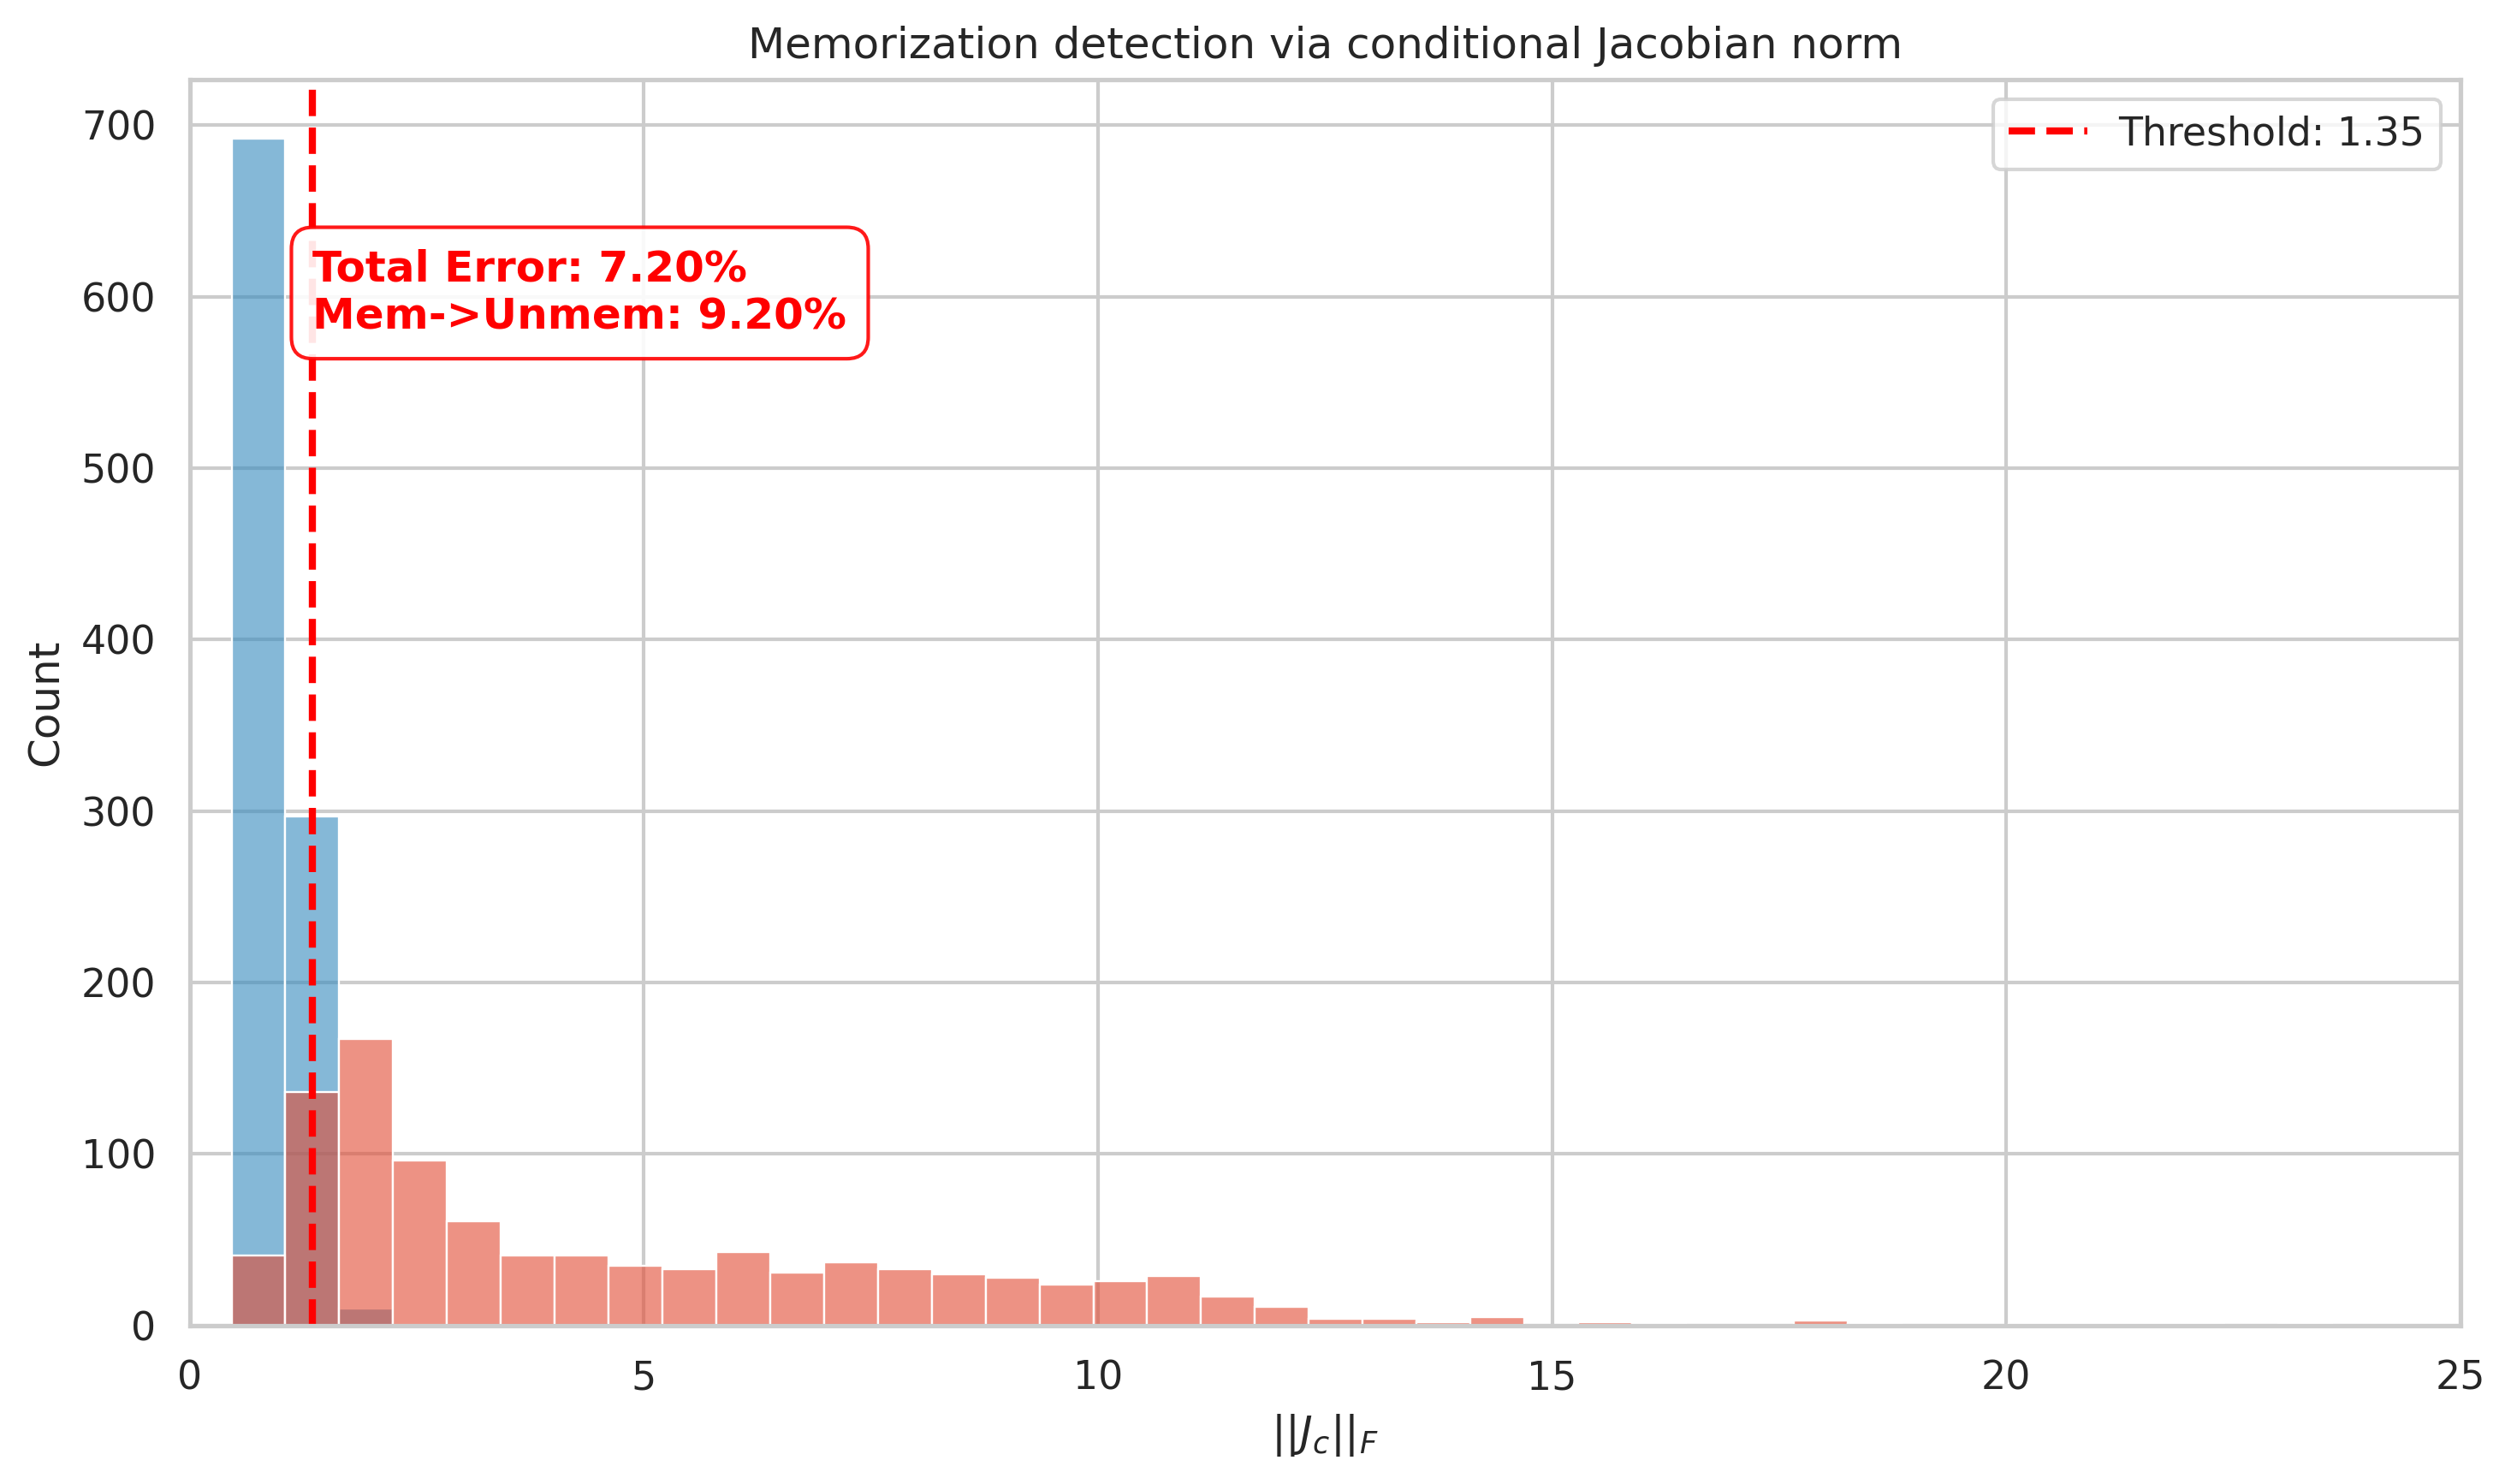

In [5]:
# 1. Plot (Sample Level)
plt.figure(figsize=(10, 6), dpi=300)

sns.histplot(
    data=df_results, 
    x="JacobianNorm", 
    hue="Group", 
    kde=False,           
    element="bars",      
    stat="count",        
    common_norm=False,   
    multiple="layer",    
    alpha=0.6,           
    palette=["#E24A33", "#348ABD"] 
)

# Threshold Line (Red)
plt.axvline(x=thresh_sample, color='red', linestyle='--', linewidth=2, label=f"Threshold: {thresh_sample:.2f}")

# Error Text (Red)
y_lim = plt.ylim()
text_x = thresh_sample
text_y = y_lim[1] * 0.80

error_text = f"Total Error: {overall_error_sample:.2f}%\nMem->Unmem: {mem_unmem_error_sample:.2f}%"

plt.text(text_x, text_y, error_text, 
         color='red', 
         fontsize=12, 
         fontweight='bold',
         bbox=dict(facecolor='white', alpha=0.9, edgecolor='red', boxstyle='round,pad=0.5'))

plt.xlabel(r"$||J_c||_F$")
plt.ylabel("Count")
plt.title("Memorization detection via conditional Jacobian norm")
plt.legend()
plt.xlim(0, 25)

plt.tight_layout()
plt.savefig("jacobian_classification_sample_level.png")
plt.show()

## 2. Prompt-Level Analysis
Averaging Jacobian Norms over 100 samples per prompt.

In [6]:
# 2. Aggregate Data (Prompt Level)
df_prompt = df_results.groupby(["Group", "Caption"])["JacobianNorm"].mean().reset_index()

print(f"Aggregated to {len(df_prompt)} prompts.")

# Calculate Threshold (Prompt Level)
thresh_prompt, acc_prompt, dir_prompt = calculate_optimal_threshold(df_prompt)
overall_error_prompt = (1 - acc_prompt) * 100

# Calculate Mem -> Unmem Error (False Negative Rate) for Prompts
mem_data_p = df_prompt[df_prompt["Group"] == "Memorized"]
n_mem_p = len(mem_data_p)

if dir_prompt == "greater":
    n_mem_err_p = (mem_data_p["JacobianNorm"] <= thresh_prompt).sum()
else:
    n_mem_err_p = (mem_data_p["JacobianNorm"] >= thresh_prompt).sum()

mem_unmem_error_prompt = (n_mem_err_p / n_mem_p) * 100

print(f"Prompt Level Results:")
print(f"Threshold: {thresh_prompt:.4f}")
print(f"Total Error: {overall_error_prompt:.2f}%")
print(f"Mem->Unmem Error: {mem_unmem_error_prompt:.2f}%")

Aggregated to 20 prompts.
Prompt Level Results:
Threshold: 1.1124
Total Error: 0.00%
Mem->Unmem Error: 0.00%


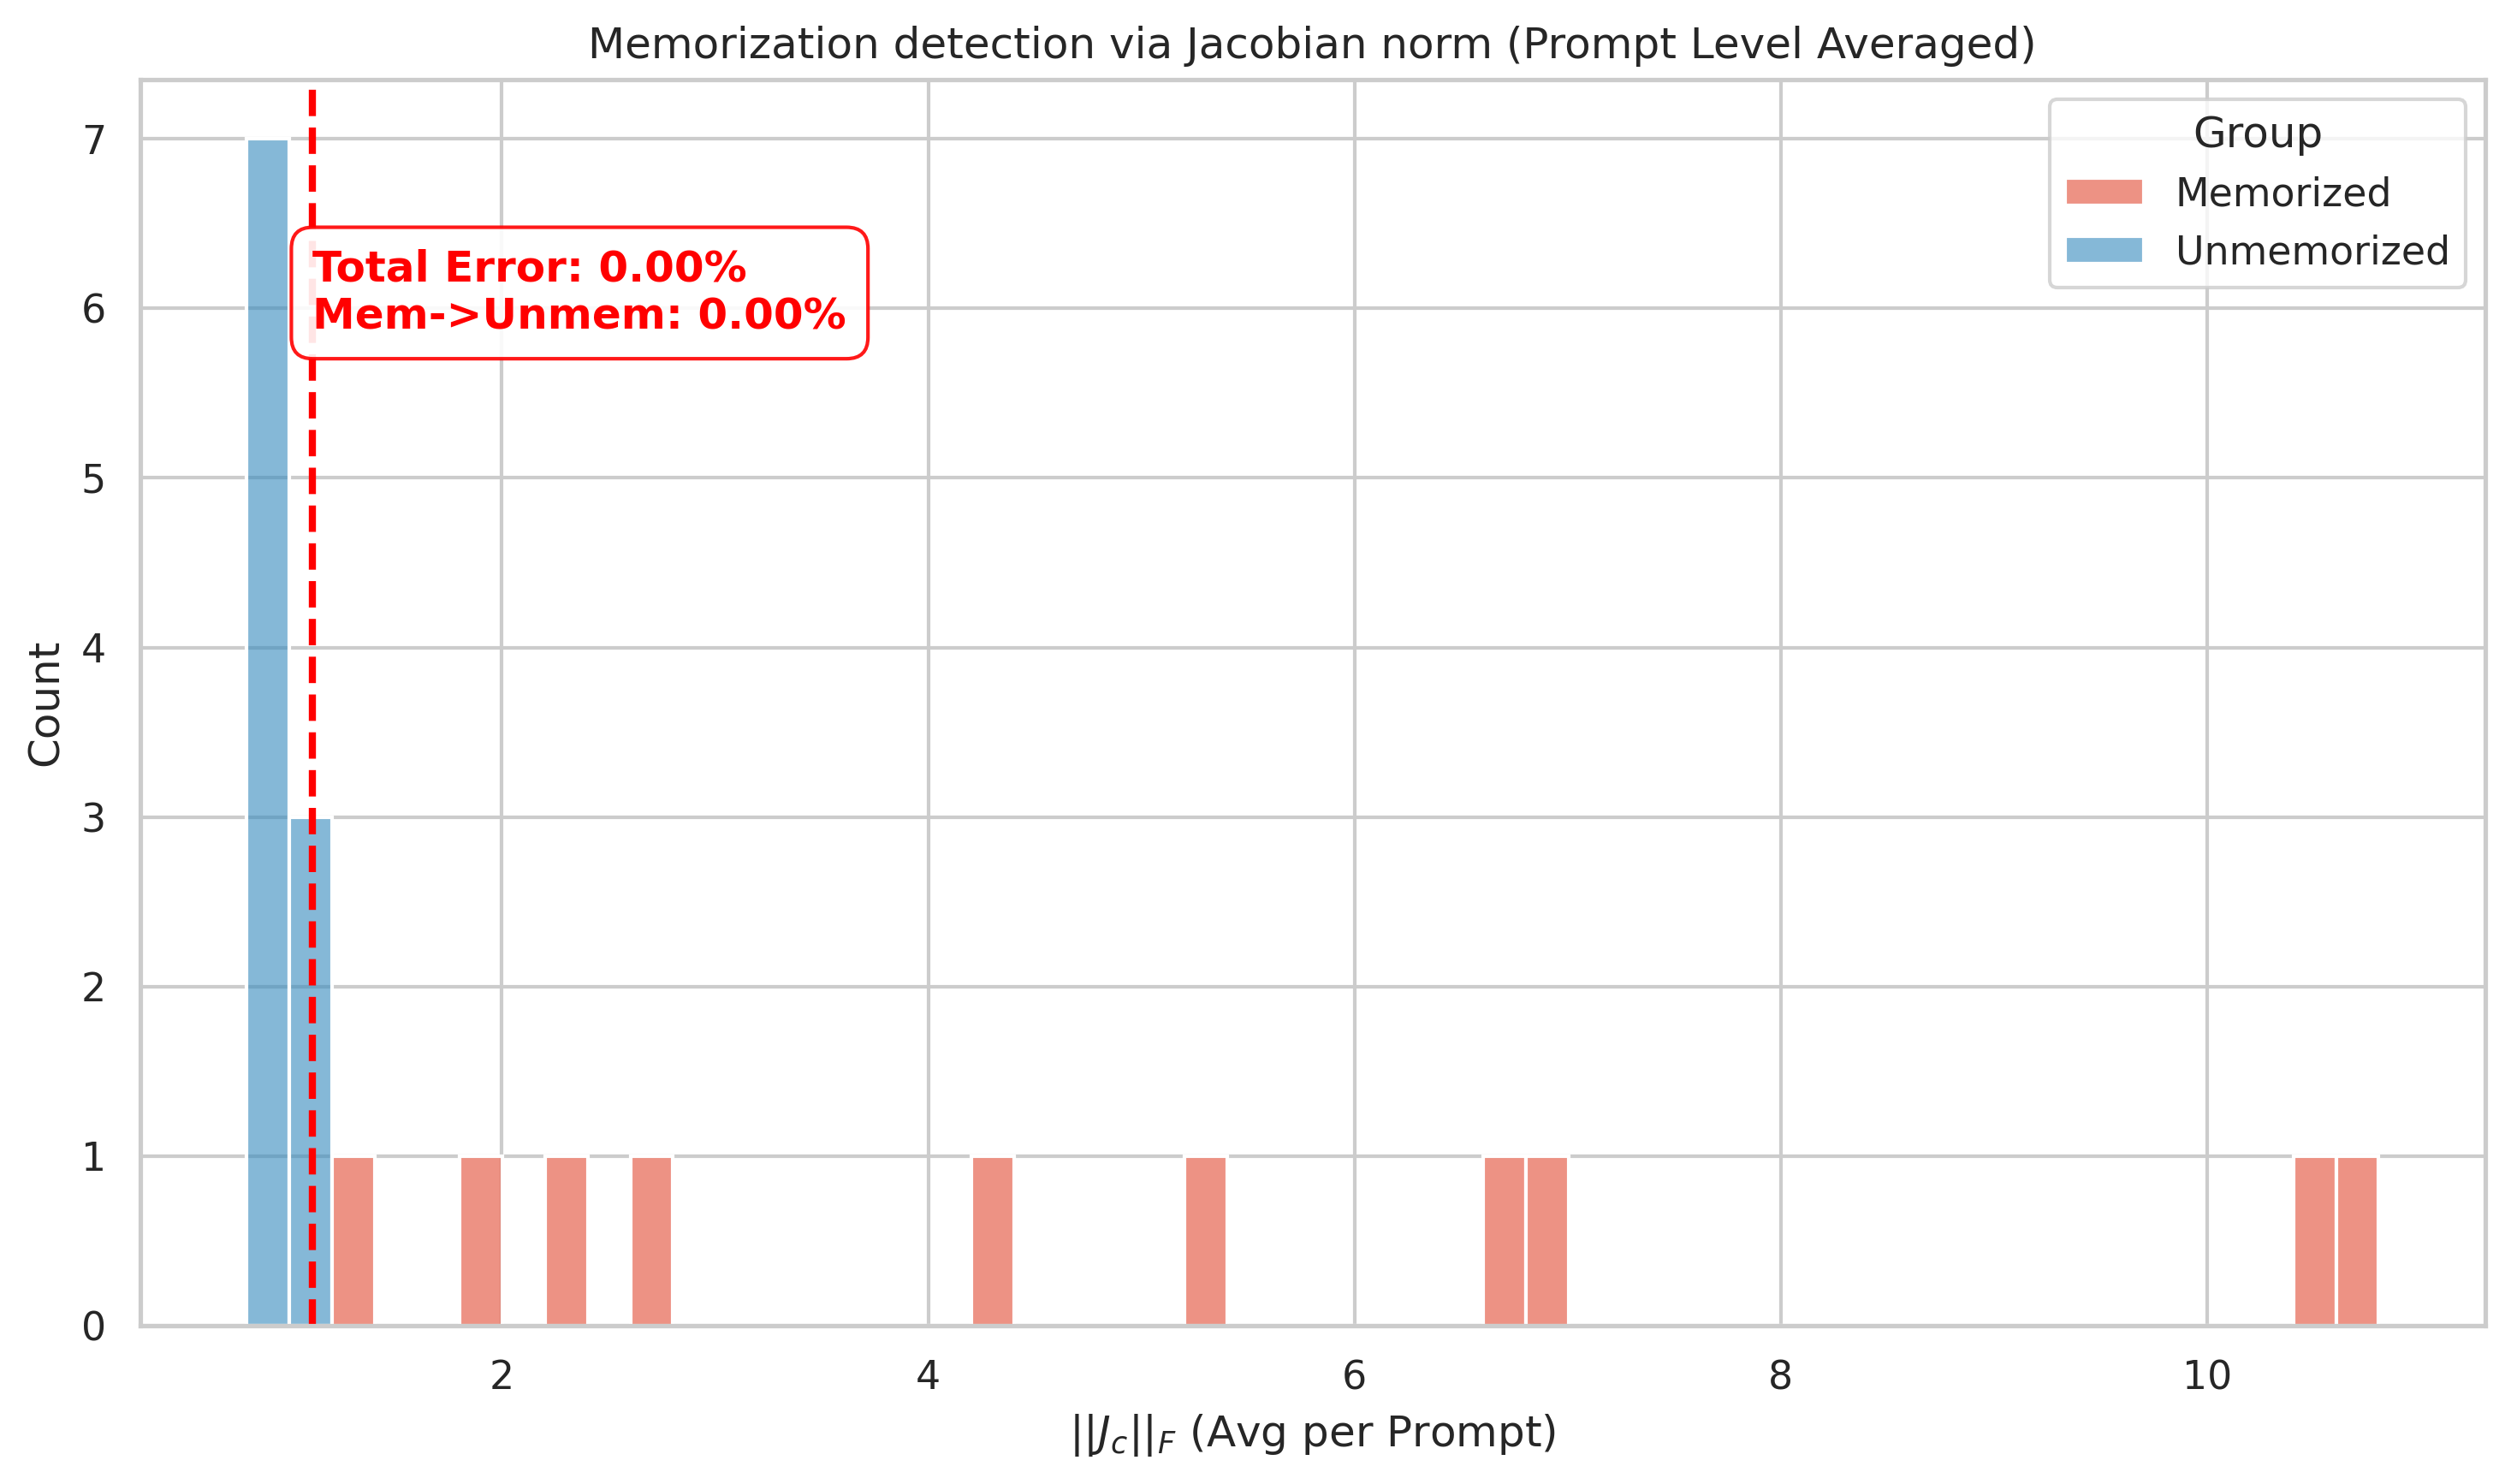

In [7]:
# 2. Plot (Prompt Level)
plt.figure(figsize=(10, 6), dpi=300)

sns.histplot(
    bins=50, 
    data=df_prompt, 
    x="JacobianNorm", 
    hue="Group", 
    kde=False,           
    element="bars",      
    stat="count",        
    common_norm=False,   
    multiple="layer",    
    alpha=0.6,           
    palette=["#E24A33", "#348ABD"] 
)

# Threshold Line (Red)
plt.axvline(x=thresh_prompt, color='red', linestyle='--', linewidth=2, label=f"Threshold: {thresh_prompt:.2f}")

# Error Text (Red)
y_lim = plt.ylim()
text_x = thresh_prompt
text_y = y_lim[1] * 0.80

error_text_p = f"Total Error: {overall_error_prompt:.2f}%\nMem->Unmem: {mem_unmem_error_prompt:.2f}%"

plt.text(text_x, text_y, error_text_p, 
         color='red', 
         fontsize=12, 
         fontweight='bold',
         bbox=dict(facecolor='white', alpha=0.9, edgecolor='red', boxstyle='round,pad=0.5'))

plt.xlabel(r"$||J_c||_F$ (Avg per Prompt)") 
plt.ylabel("Count")
plt.title("Memorization detection via Jacobian norm (Prompt Level Averaged)")

plt.tight_layout()
plt.savefig("jacobian_classification_prompt_level.png")
plt.show()

Calculating robust statistics and generating plots...
Processing: 1. Median
Processing: 2. Trimmed Mean (10%)
Processing: 3. Winsorized Mean (10%)
Processing: 4. Huber M-estimator
Processing: 5. Tukey Biweight
Processing: 6. Top 30 Mean


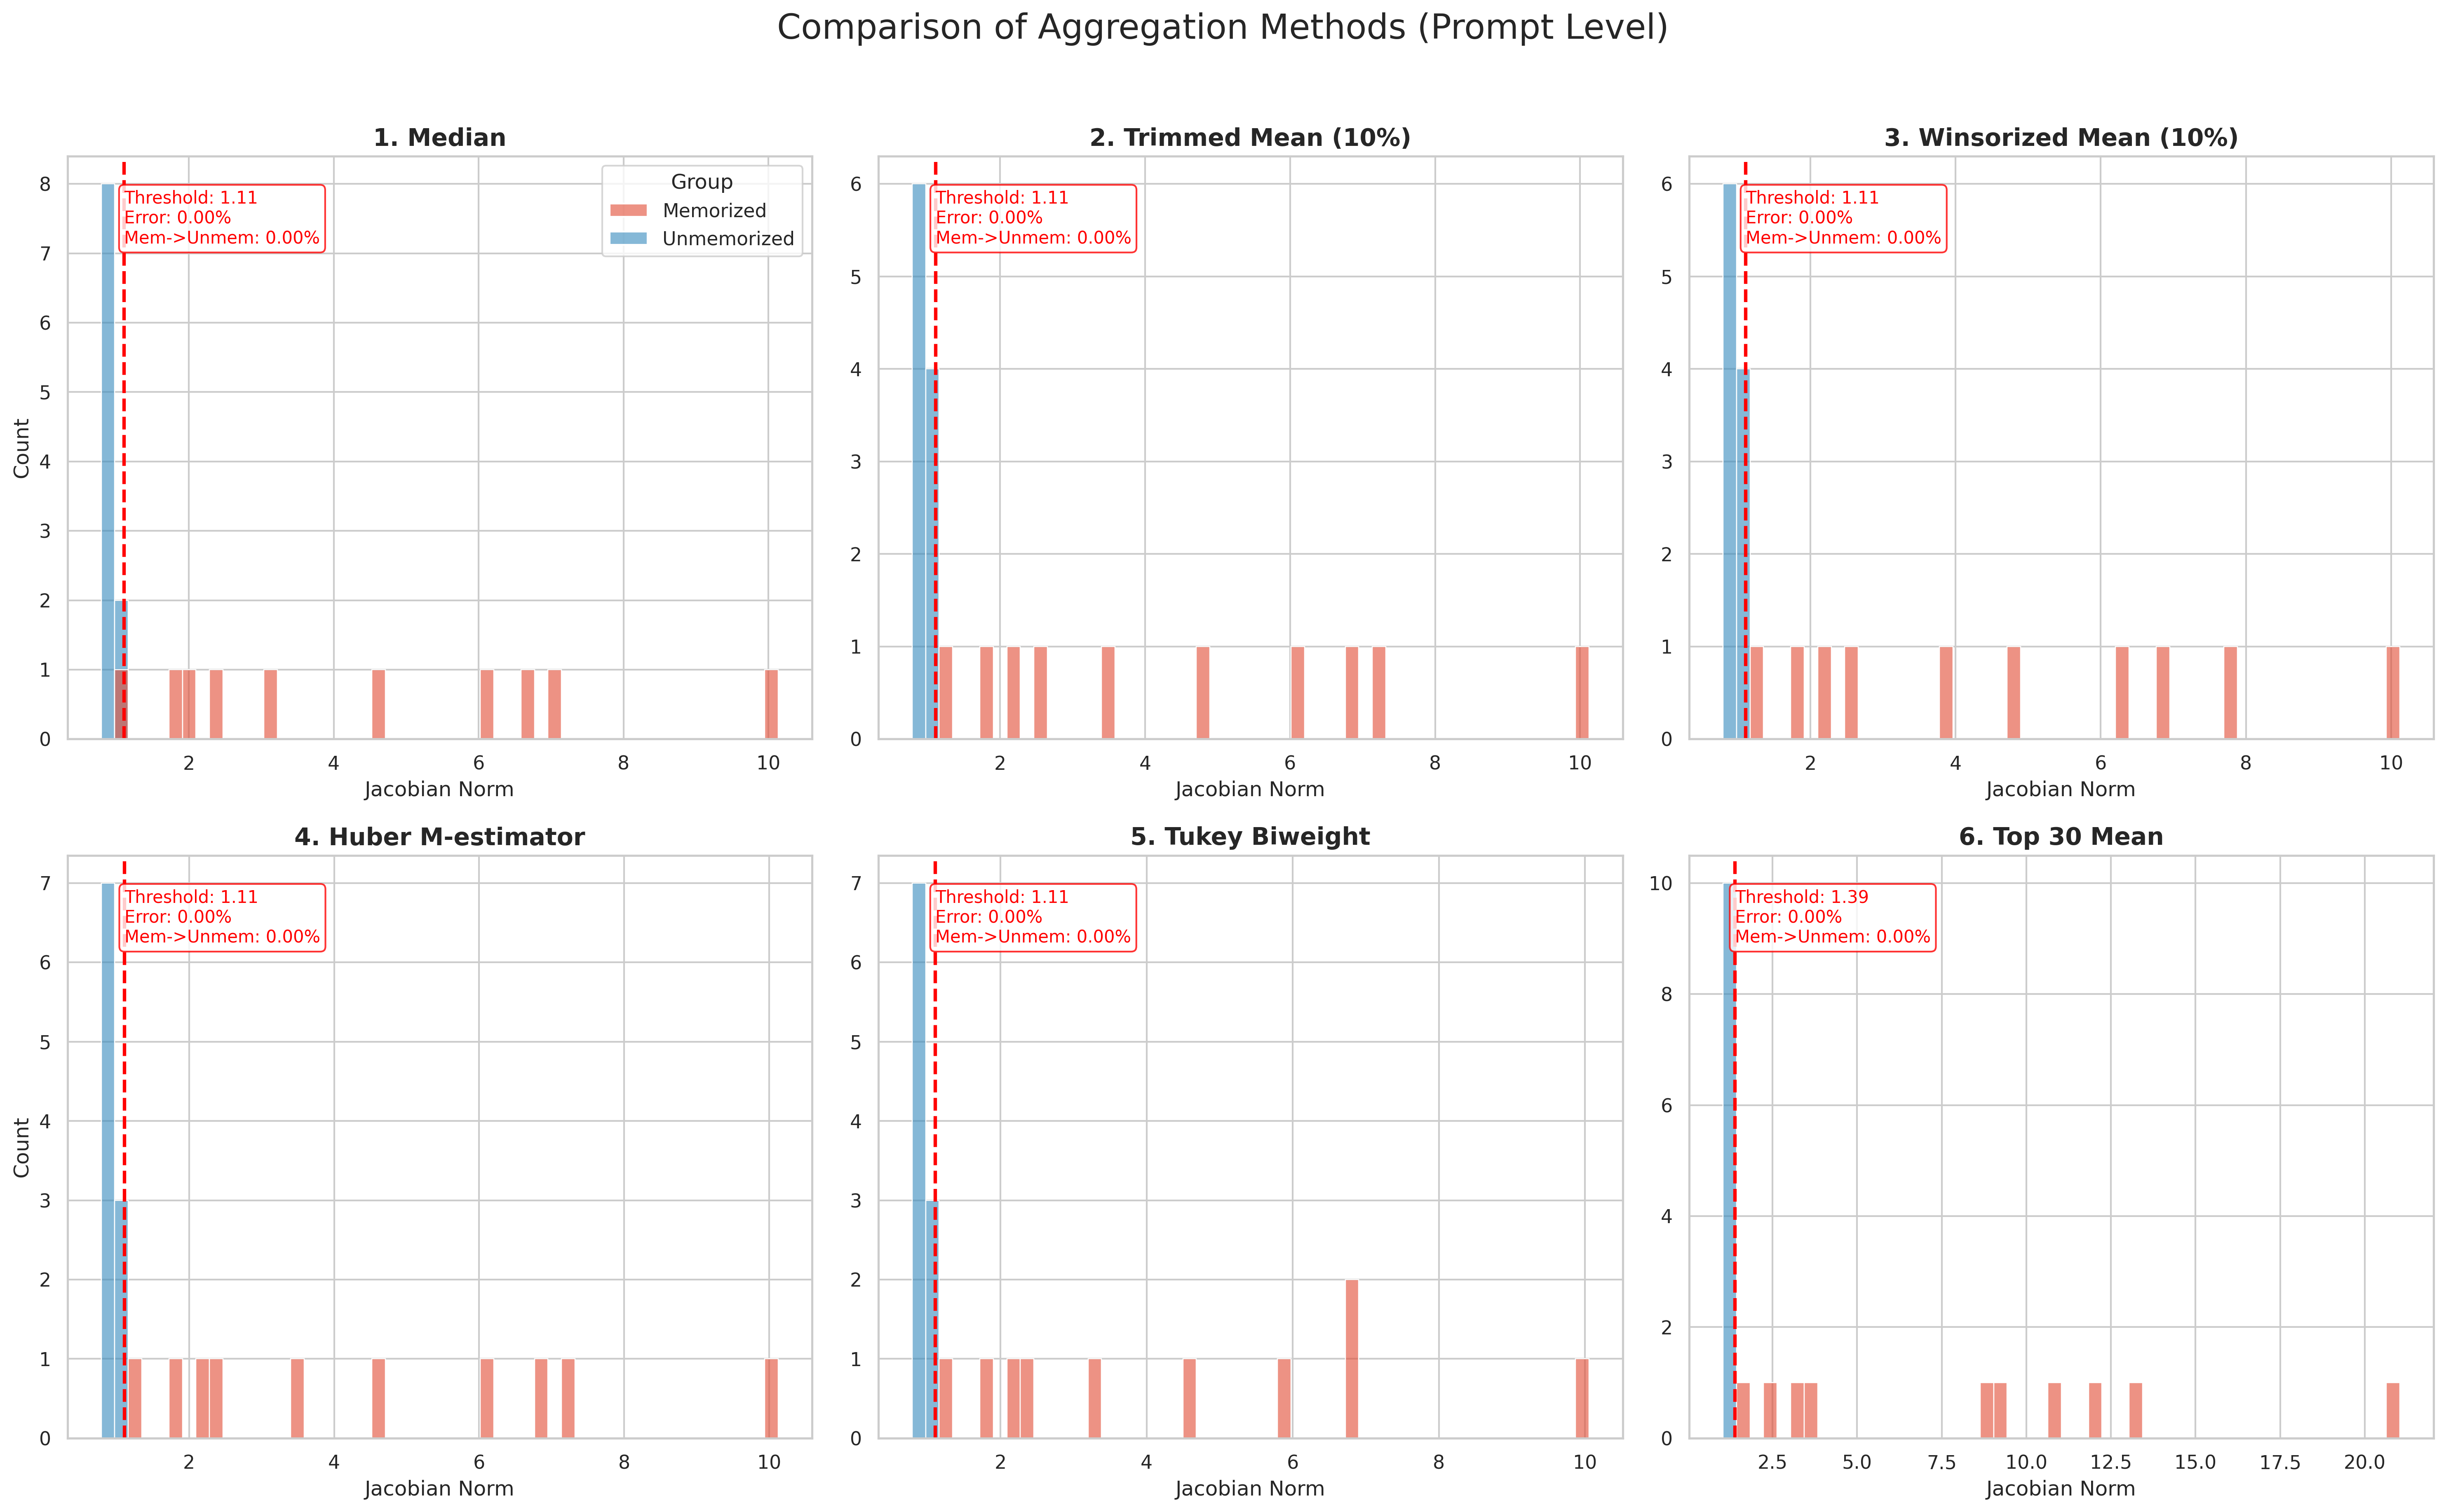

In [8]:

from scipy import stats

# --- Robust Location Estimators ---
def robust_location(x, weight_func, scale_factor=1.4826):
    """Iteratively reweighted least squares for location."""
    x = np.array(x)
    mad = np.median(np.abs(x - np.median(x)))
    scale = mad * scale_factor
    if scale < 1e-9: return np.median(x)
    
    mu = np.median(x)
    for _ in range(20):
        r = (x - mu) / scale
        w = weight_func(r)
        if np.sum(w) == 0: break
        mu_new = np.sum(w * x) / np.sum(w)
        if np.abs(mu - mu_new) < 1e-6: break
        mu = mu_new
    return mu

def weight_huber(r, k=1.345):
    # w = psi(r)/r. For Huber: psi(r) = r if |r|<k else k*sgn(r)
    # w = 1 if |r|<k else k/|r|
    return np.where(np.abs(r) <= k, 1.0, k / (np.abs(r) + 1e-9))

def weight_tukey(r, c=4.685):
    # Tukey biweight weights
    return np.where(np.abs(r) <= c, (1 - (r/c)**2)**2, 0.0)

def huber_estimator(x):
    return robust_location(x, weight_huber)

def tukey_estimator(x):
    return robust_location(x, weight_tukey)

def winsorized_mean_10(x):
    # Winsorize 10% from both tails
    return np.mean(stats.mstats.winsorize(x, limits=[0.1, 0.1]))

def top_30_mean(x):
    return np.mean(sorted(x, reverse=True)[:30])

# --- Analysis Configuration ---
methods = {
    "1. Median": np.median,
    "2. Trimmed Mean (10%)": lambda x: stats.trim_mean(x, 0.1),
    "3. Winsorized Mean (10%)": winsorized_mean_10,
    "4. Huber M-estimator": huber_estimator,
    "5. Tukey Biweight": tukey_estimator,
    "6. Top 30 Mean": top_30_mean
}

# --- Plotting ---
fig, axes = plt.subplots(2, 3, figsize=(20, 12), dpi=300)
axes = axes.flatten()

print("Calculating robust statistics and generating plots...")

for i, (name, func) in enumerate(methods.items()):
    print(f"Processing: {name}")
    
    # Aggregation
    # Group by Group & Caption, then apply function
    # Note: This might take a few seconds
    df_agg = df_results.groupby(["Group", "Caption"])["JacobianNorm"].apply(func).reset_index()
    
    # Threshold & Error
    thresh, acc, direction = calculate_optimal_threshold(df_agg)
    error = (1 - acc) * 100
    
    # Mem -> Unmem Error
    mem_data = df_agg[df_agg["Group"] == "Memorized"]
    n_mem = len(mem_data)
    if direction == "greater":
        n_mem_err = (mem_data["JacobianNorm"] <= thresh).sum()
    else:
        n_mem_err = (mem_data["JacobianNorm"] >= thresh).sum()
    mem_unmem_error = (n_mem_err / n_mem) * 100
    
    # Plot
    ax = axes[i]
    sns.histplot(
        data=df_agg, 
        x="JacobianNorm", 
        hue="Group", 
        bins=50, 
        kde=False, 
        element="bars", 
        stat="count", 
        common_norm=False,
        palette=["#E24A33", "#348ABD"],
        alpha=0.6,
        ax=ax,
        legend=(i==0) # Only show legend on first plot to save space, or handle separately
    )
    
    # Decorations
    ax.set_title(f"{name}", fontsize=14, fontweight='bold')
    ax.axvline(x=thresh, color='red', linestyle='--', linewidth=2)
    
    # Text Stats
    y_lim = ax.get_ylim()
    text_y = y_lim[1] * 0.85
    stats_text = f"Threshold: {thresh:.2f}\nError: {error:.2f}%\nMem->Unmem: {mem_unmem_error:.2f}%"
    ax.text(thresh, text_y, stats_text, color='red', fontsize=10, 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='red', boxstyle='round,pad=0.3'))
    
    ax.set_xlabel("Jacobian Norm")
    if i % 3 != 0:
        ax.set_ylabel("")

plt.suptitle("Comparison of Aggregation Methods (Prompt Level)", fontsize=20, y=1.02)
plt.tight_layout()
plt.savefig("jacobian_classification_robust_methods.png")
plt.show()


Calculating advanced statistics and generating plots...
Processing: 1. LogSumExp / Softmax Pooling
Processing: 2. Thresholded Top-k Sum (k=30, th=1.6)
Processing: 3. Signed Margin Pooling (ref=1.6)
Processing: 4. Piecewise Power (ref=1.6, p=2)


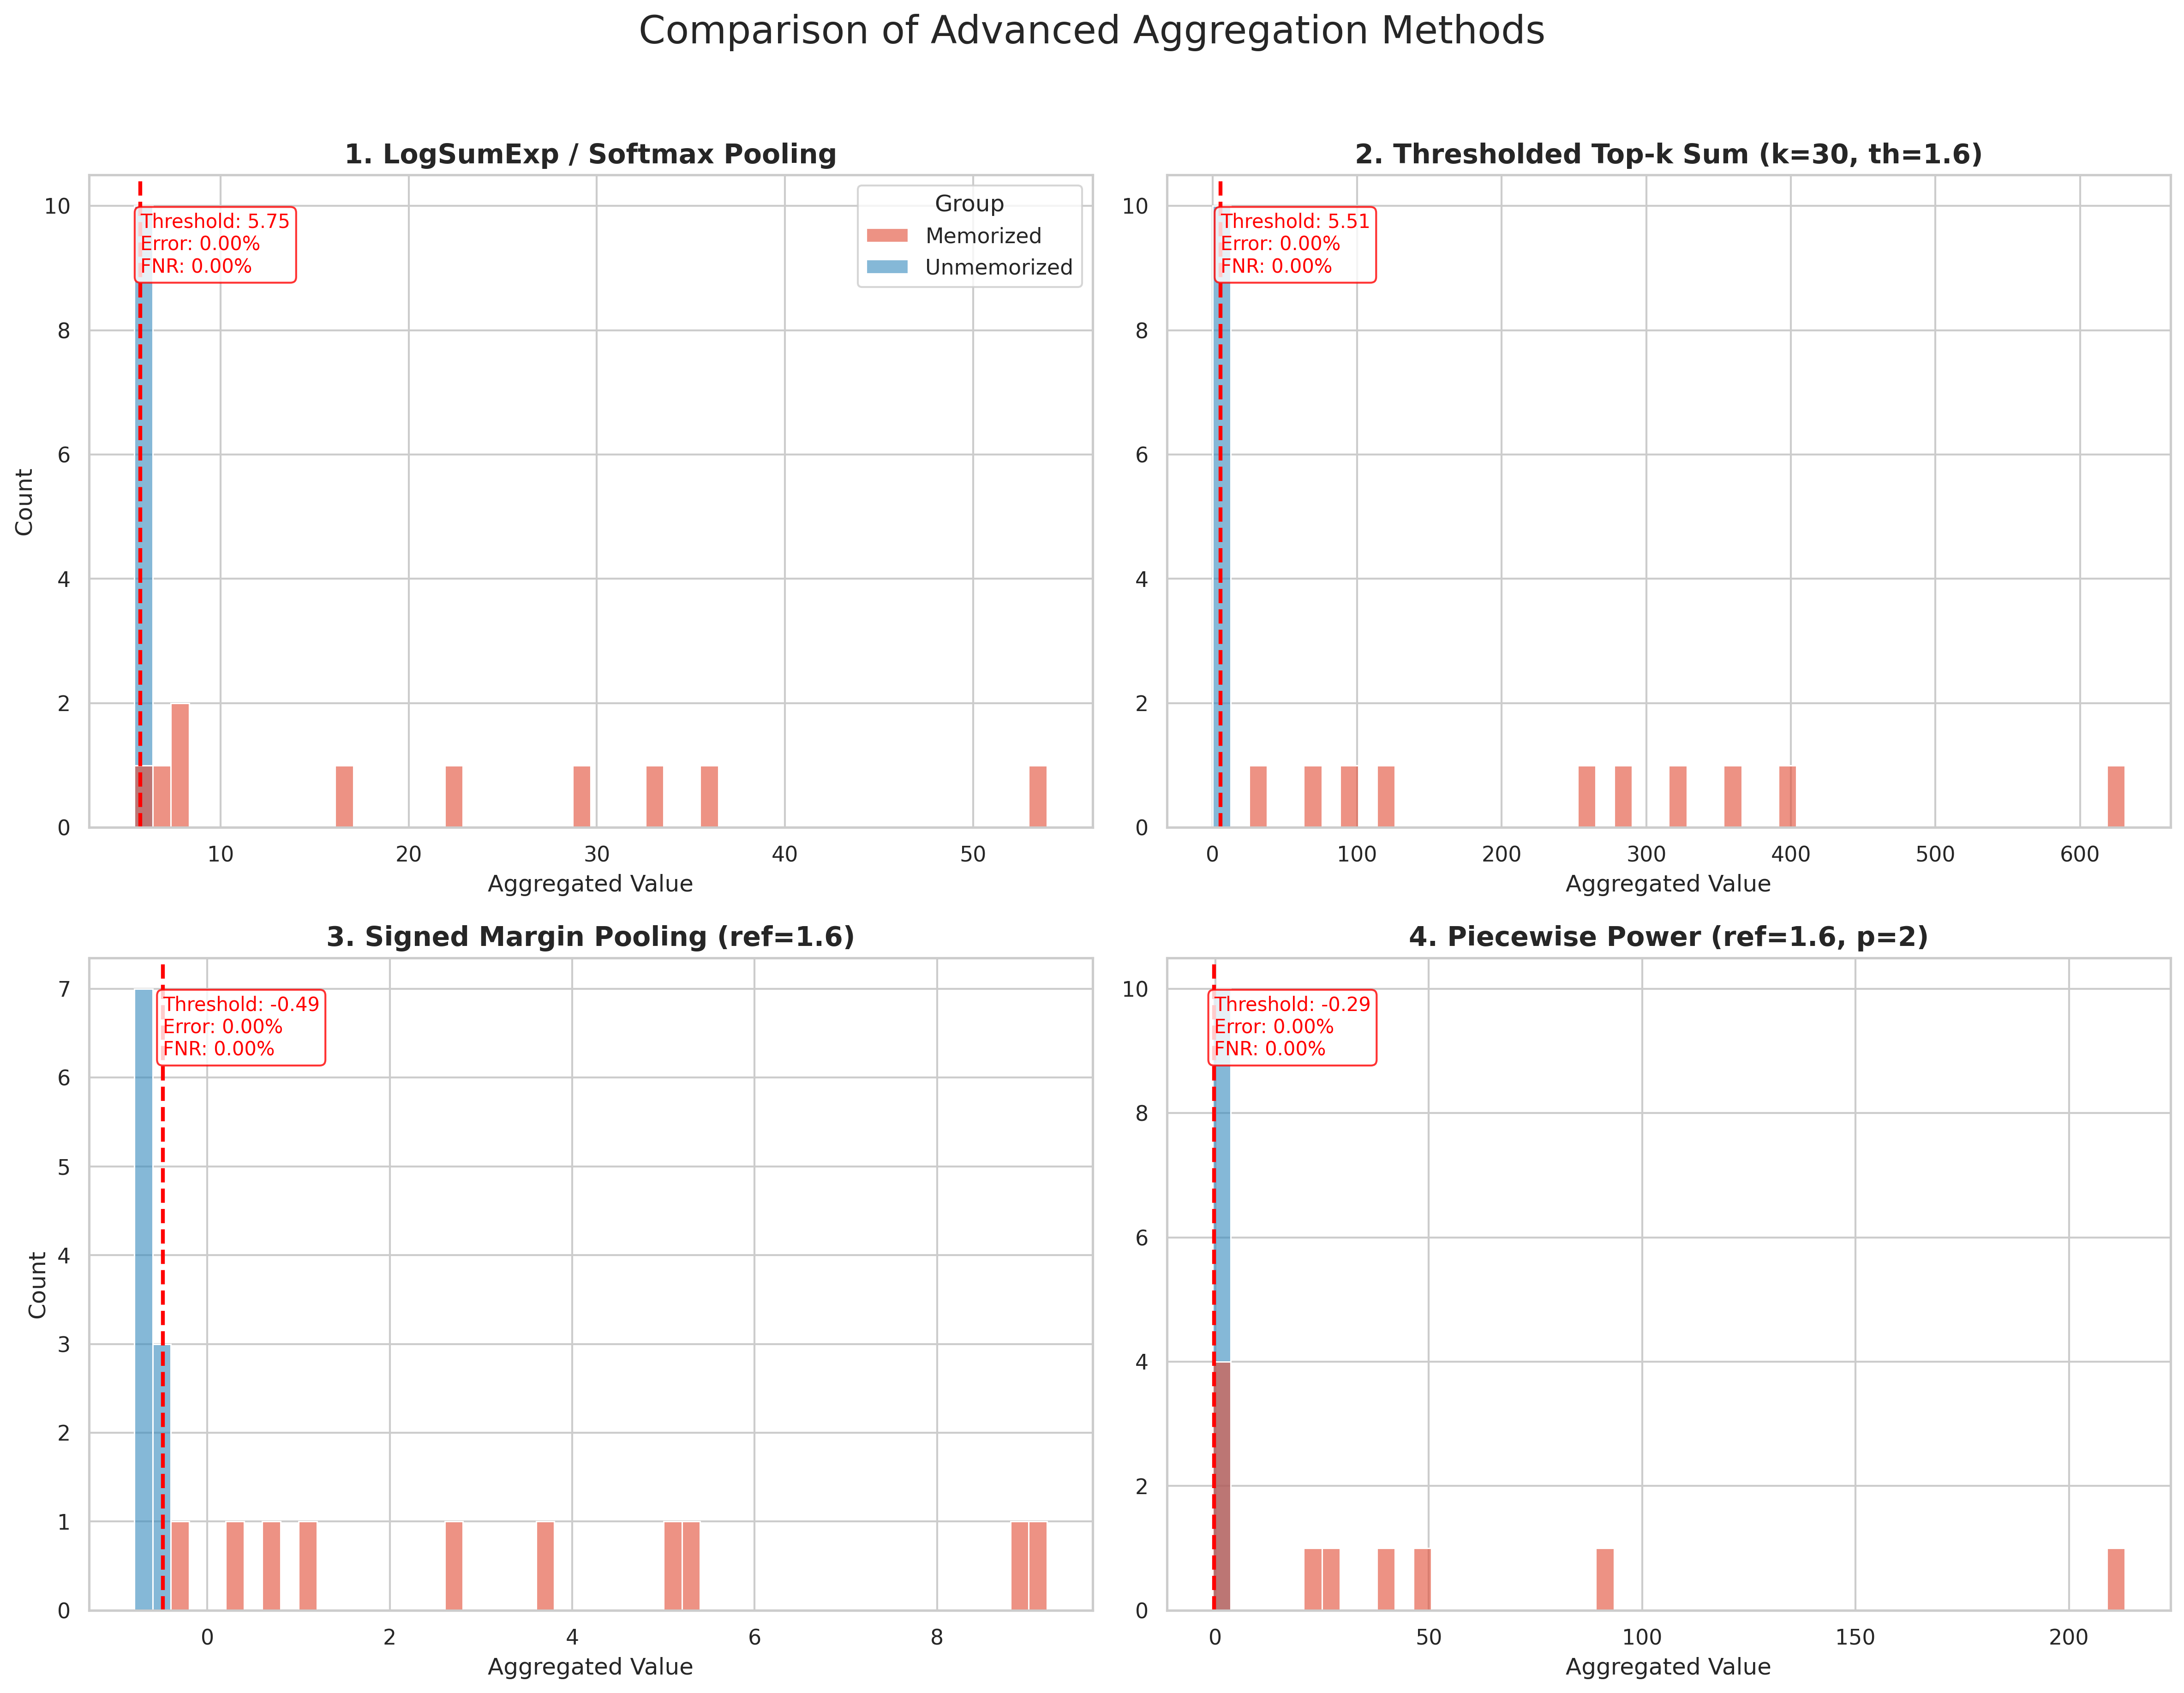

In [9]:

from scipy.special import logsumexp

# --- Advanced Aggregation Functions ---

def logsumexp_func(x):
    # LogSumExp pooling
    return logsumexp(x)

def thresholded_top_k_sum(x, k=30, threshold=1.6):
    # Sum of top k elements that exceed the threshold
    x = np.array(x)
    filtered = x[x > threshold]
    if len(filtered) == 0:
        return 0.0
    top_k = sorted(filtered, reverse=True)[:k]
    return np.sum(top_k)

def signed_margin_pooling(x, ref=1.6):
    # Mean of (x - ref)
    return np.mean(np.array(x) - ref)

def piecewise_power(x, ref=1.6, p=2):
    # Mean of sign(x-ref) * |x-ref|^p
    x = np.array(x)
    diff = x - ref
    return np.mean(np.sign(diff) * np.power(np.abs(diff), p))

# --- Analysis Configuration ---
adv_methods = {
    "1. LogSumExp / Softmax Pooling": logsumexp_func,
    "2. Thresholded Top-k Sum (k=30, th=1.6)": thresholded_top_k_sum,
    "3. Signed Margin Pooling (ref=1.6)": signed_margin_pooling,
    "4. Piecewise Power (ref=1.6, p=2)": piecewise_power
}

# --- Plotting ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12), dpi=300)
axes = axes.flatten()

print("Calculating advanced statistics and generating plots...")

for i, (name, func) in enumerate(adv_methods.items()):
    print(f"Processing: {name}")
    
    # Aggregation
    # Group by Group & Caption, then apply function
    df_agg = df_results.groupby(["Group", "Caption"])["JacobianNorm"].apply(func).reset_index()
    
    # Threshold & Error
    thresh, acc, direction = calculate_optimal_threshold(df_agg)
    error = (1 - acc) * 100
    
    # Mem -> Unmem Error (False Negative Rate)
    mem_data = df_agg[df_agg["Group"] == "Memorized"]
    n_mem = len(mem_data)
    if direction == "greater":
        n_mem_err = (mem_data["JacobianNorm"] <= thresh).sum()
    else:
        n_mem_err = (mem_data["JacobianNorm"] >= thresh).sum()
    mem_unmem_error = (n_mem_err / n_mem) * 100
    
    # Plot
    ax = axes[i]
    sns.histplot(
        data=df_agg, 
        x="JacobianNorm", 
        hue="Group", 
        bins=50, 
        kde=False, 
        element="bars", 
        stat="count", 
        common_norm=False,
        palette=["#E24A33", "#348ABD"],
        alpha=0.6,
        ax=ax,
        legend=(i==0)
    )
    
    # Decorations
    ax.set_title(f"{name}", fontsize=14, fontweight='bold')
    ax.axvline(x=thresh, color='red', linestyle='--', linewidth=2)
    
    # Text Stats
    y_lim = ax.get_ylim()
    text_y = y_lim[1] * 0.85
    stats_text = f"Threshold: {thresh:.2f}\nError: {error:.2f}%\nFNR: {mem_unmem_error:.2f}%"
    ax.text(thresh, text_y, stats_text, color='red', fontsize=10, 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='red', boxstyle='round,pad=0.3'))
    
    ax.set_xlabel("Aggregated Value")
    if i % 2 != 0:
        ax.set_ylabel("")

plt.suptitle("Comparison of Advanced Aggregation Methods", fontsize=20, y=1.02)
plt.tight_layout()
plt.savefig("jacobian_classification_advanced_methods.png")
plt.show()


Performing ROC Analysis on Sample Level Data (First Plot)...
Sample Level ROC Results:
AUC: 0.9651
TPR at 1% FPR: 0.8210 (at FPR=0.0100)


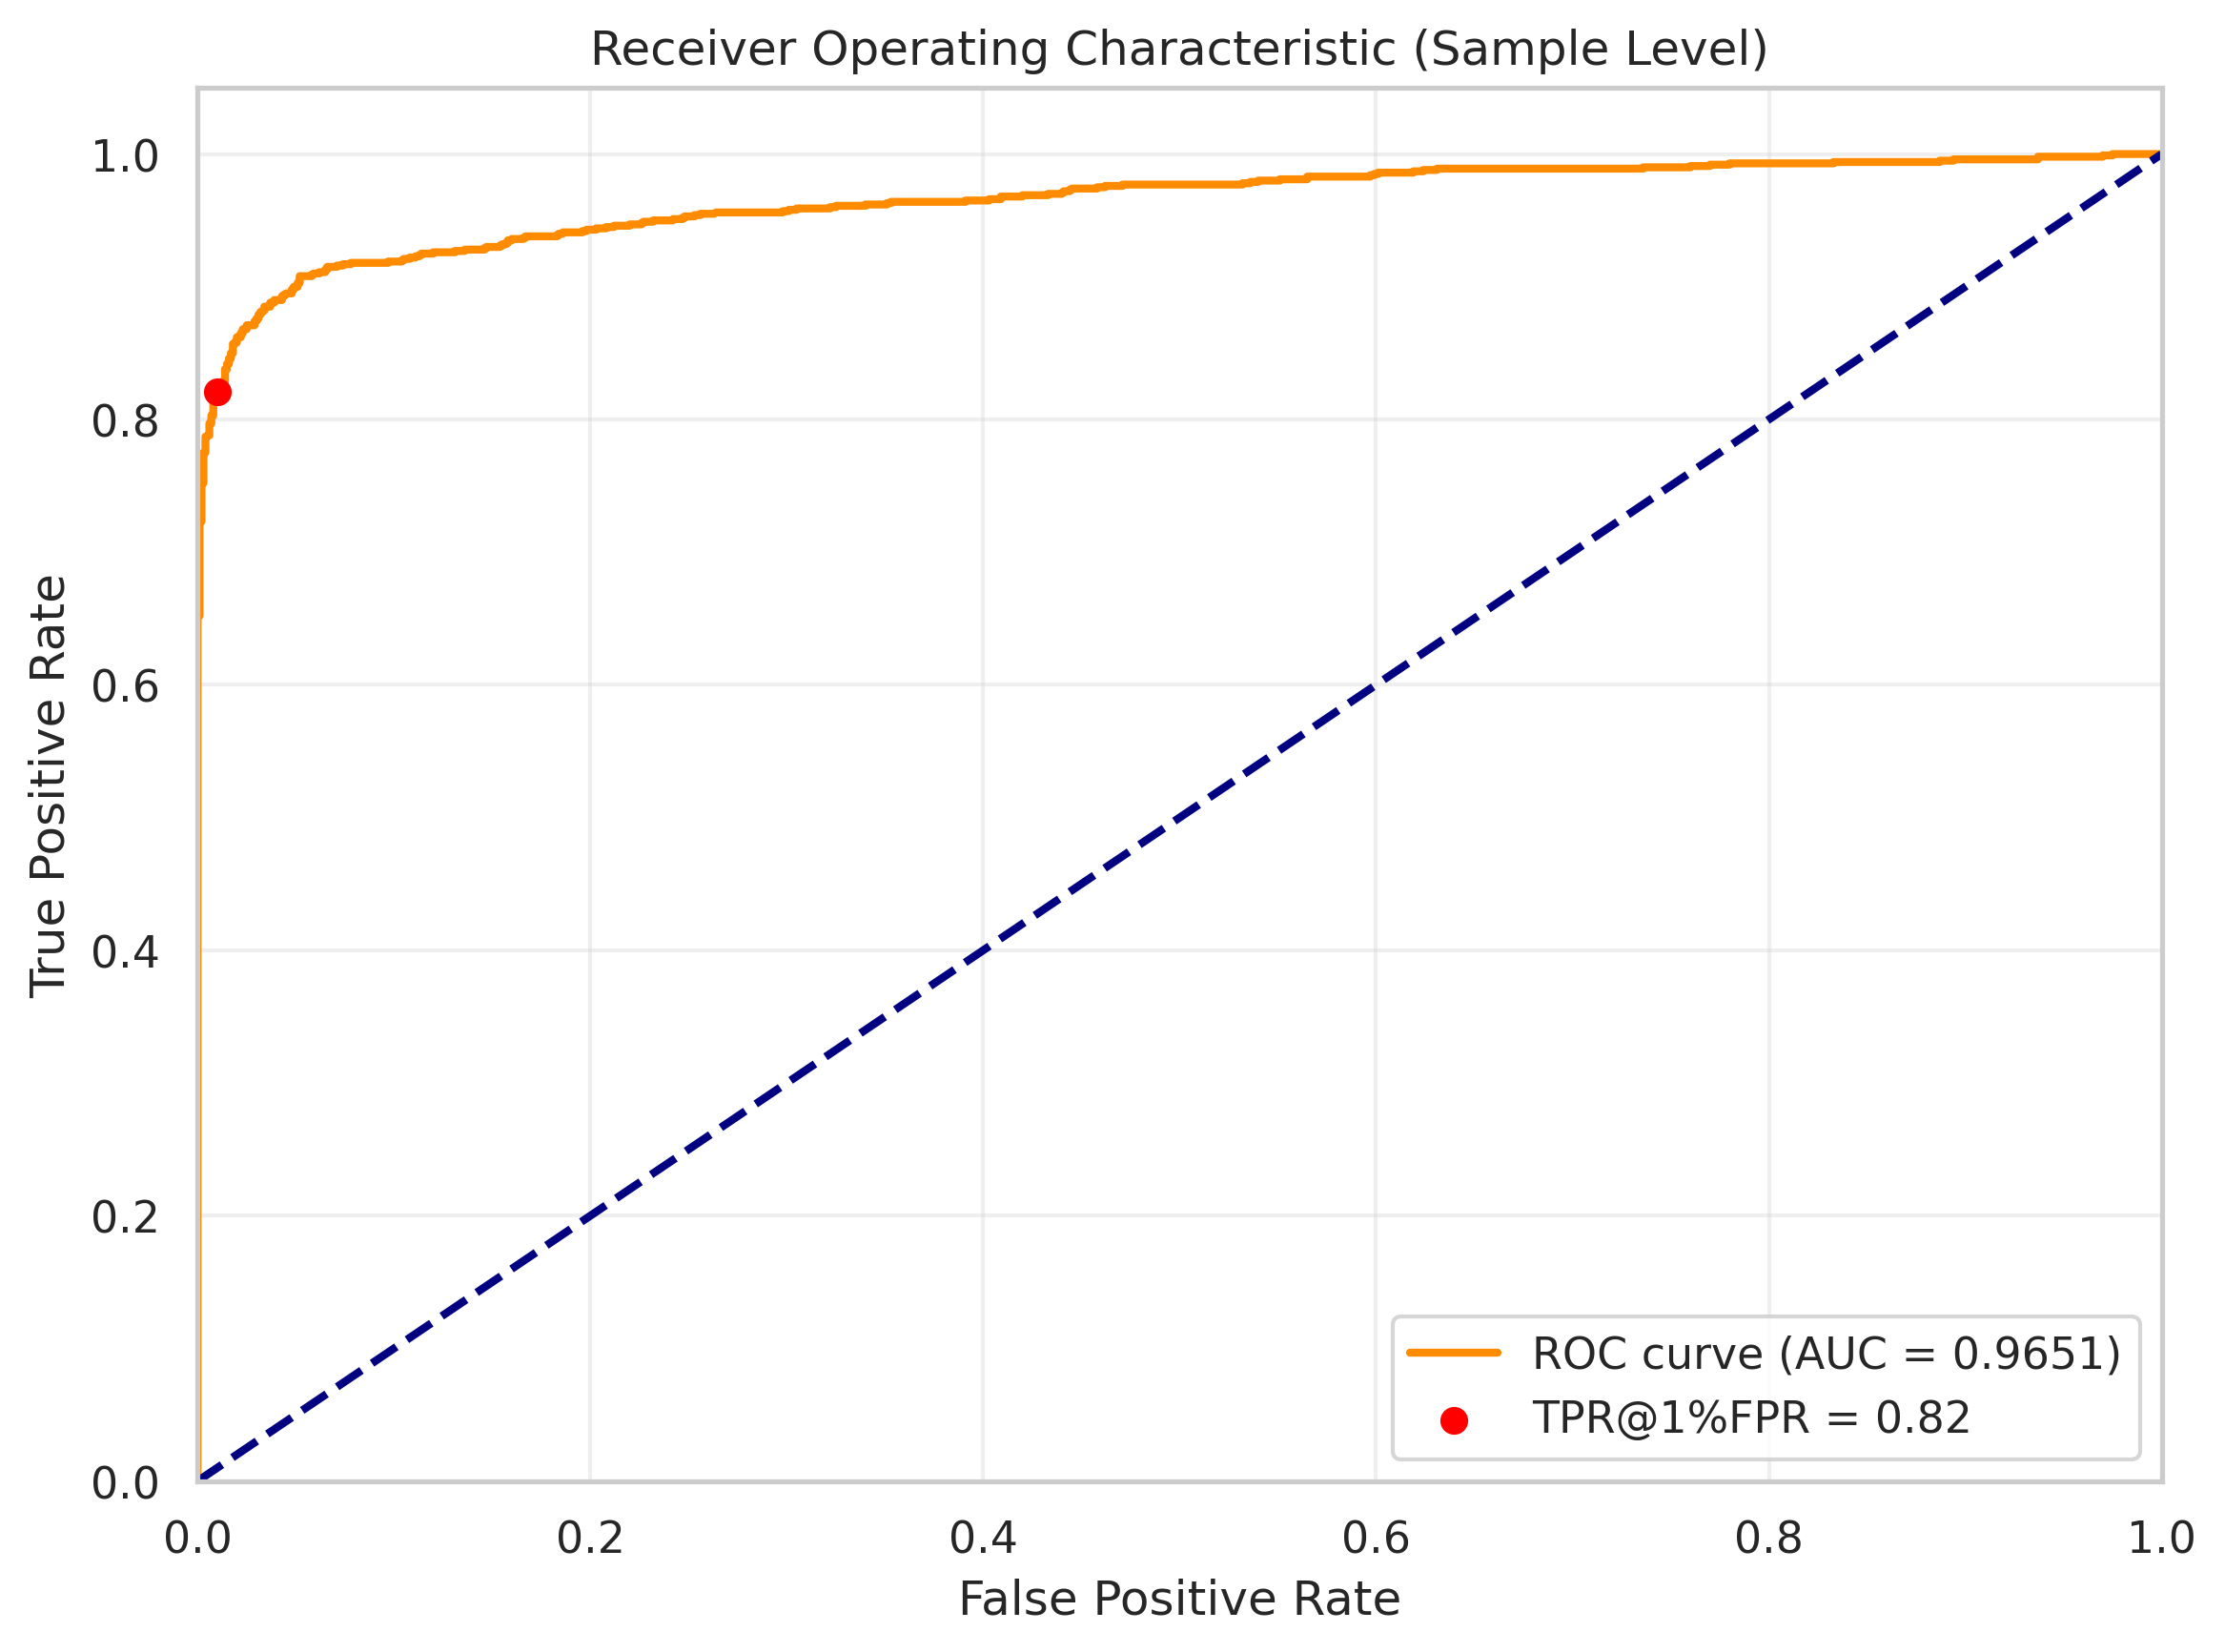

In [10]:

from sklearn.metrics import roc_curve, auc

print("Performing ROC Analysis on Sample Level Data (First Plot)...")

# Prepare data
y_true = (df_results["Group"] == "Memorized").astype(int)
y_scores = df_results["JacobianNorm"]

# Calculate ROC and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Check directionality. If AUC < 0.5, it implies Memorized samples have lower values than Unmemorized.
# In that case, we invert the scores to interpret "Memorized" as the positive class correctly.
if roc_auc < 0.5:
    y_scores = -y_scores
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

# Calculate TPR at 1% FPR
# We find the thresholds where FPR <= 0.01
valid_indices = np.where(fpr <= 0.01)[0]
if len(valid_indices) > 0:
    # The last index where FPR <= 0.01 corresponds to the highest TPR for that FPR constraint
    idx_1pct = valid_indices[-1]
    tpr_at_1pct_fpr = tpr[idx_1pct]
    actual_fpr = fpr[idx_1pct]
else:
    tpr_at_1pct_fpr = 0.0
    actual_fpr = 0.0

print(f"Sample Level ROC Results:")
print(f"AUC: {roc_auc:.4f}")
print(f"TPR at 1% FPR: {tpr_at_1pct_fpr:.4f} (at FPR={actual_fpr:.4f})")

# Plot ROC Curve
plt.figure(figsize=(8, 6), dpi=300)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(actual_fpr, tpr_at_1pct_fpr, color='red', zorder=5, label=f'TPR@1%FPR = {tpr_at_1pct_fpr:.2f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Sample Level)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("jacobian_classification_sample_roc.png")
plt.show()



Performing ROC Analysis on Random Subsampling (k=4)...
Subsampling (k=4) ROC Results:
AUC: 1.0000
TPR at 1% FPR: 1.0000 (at FPR=0.0000)


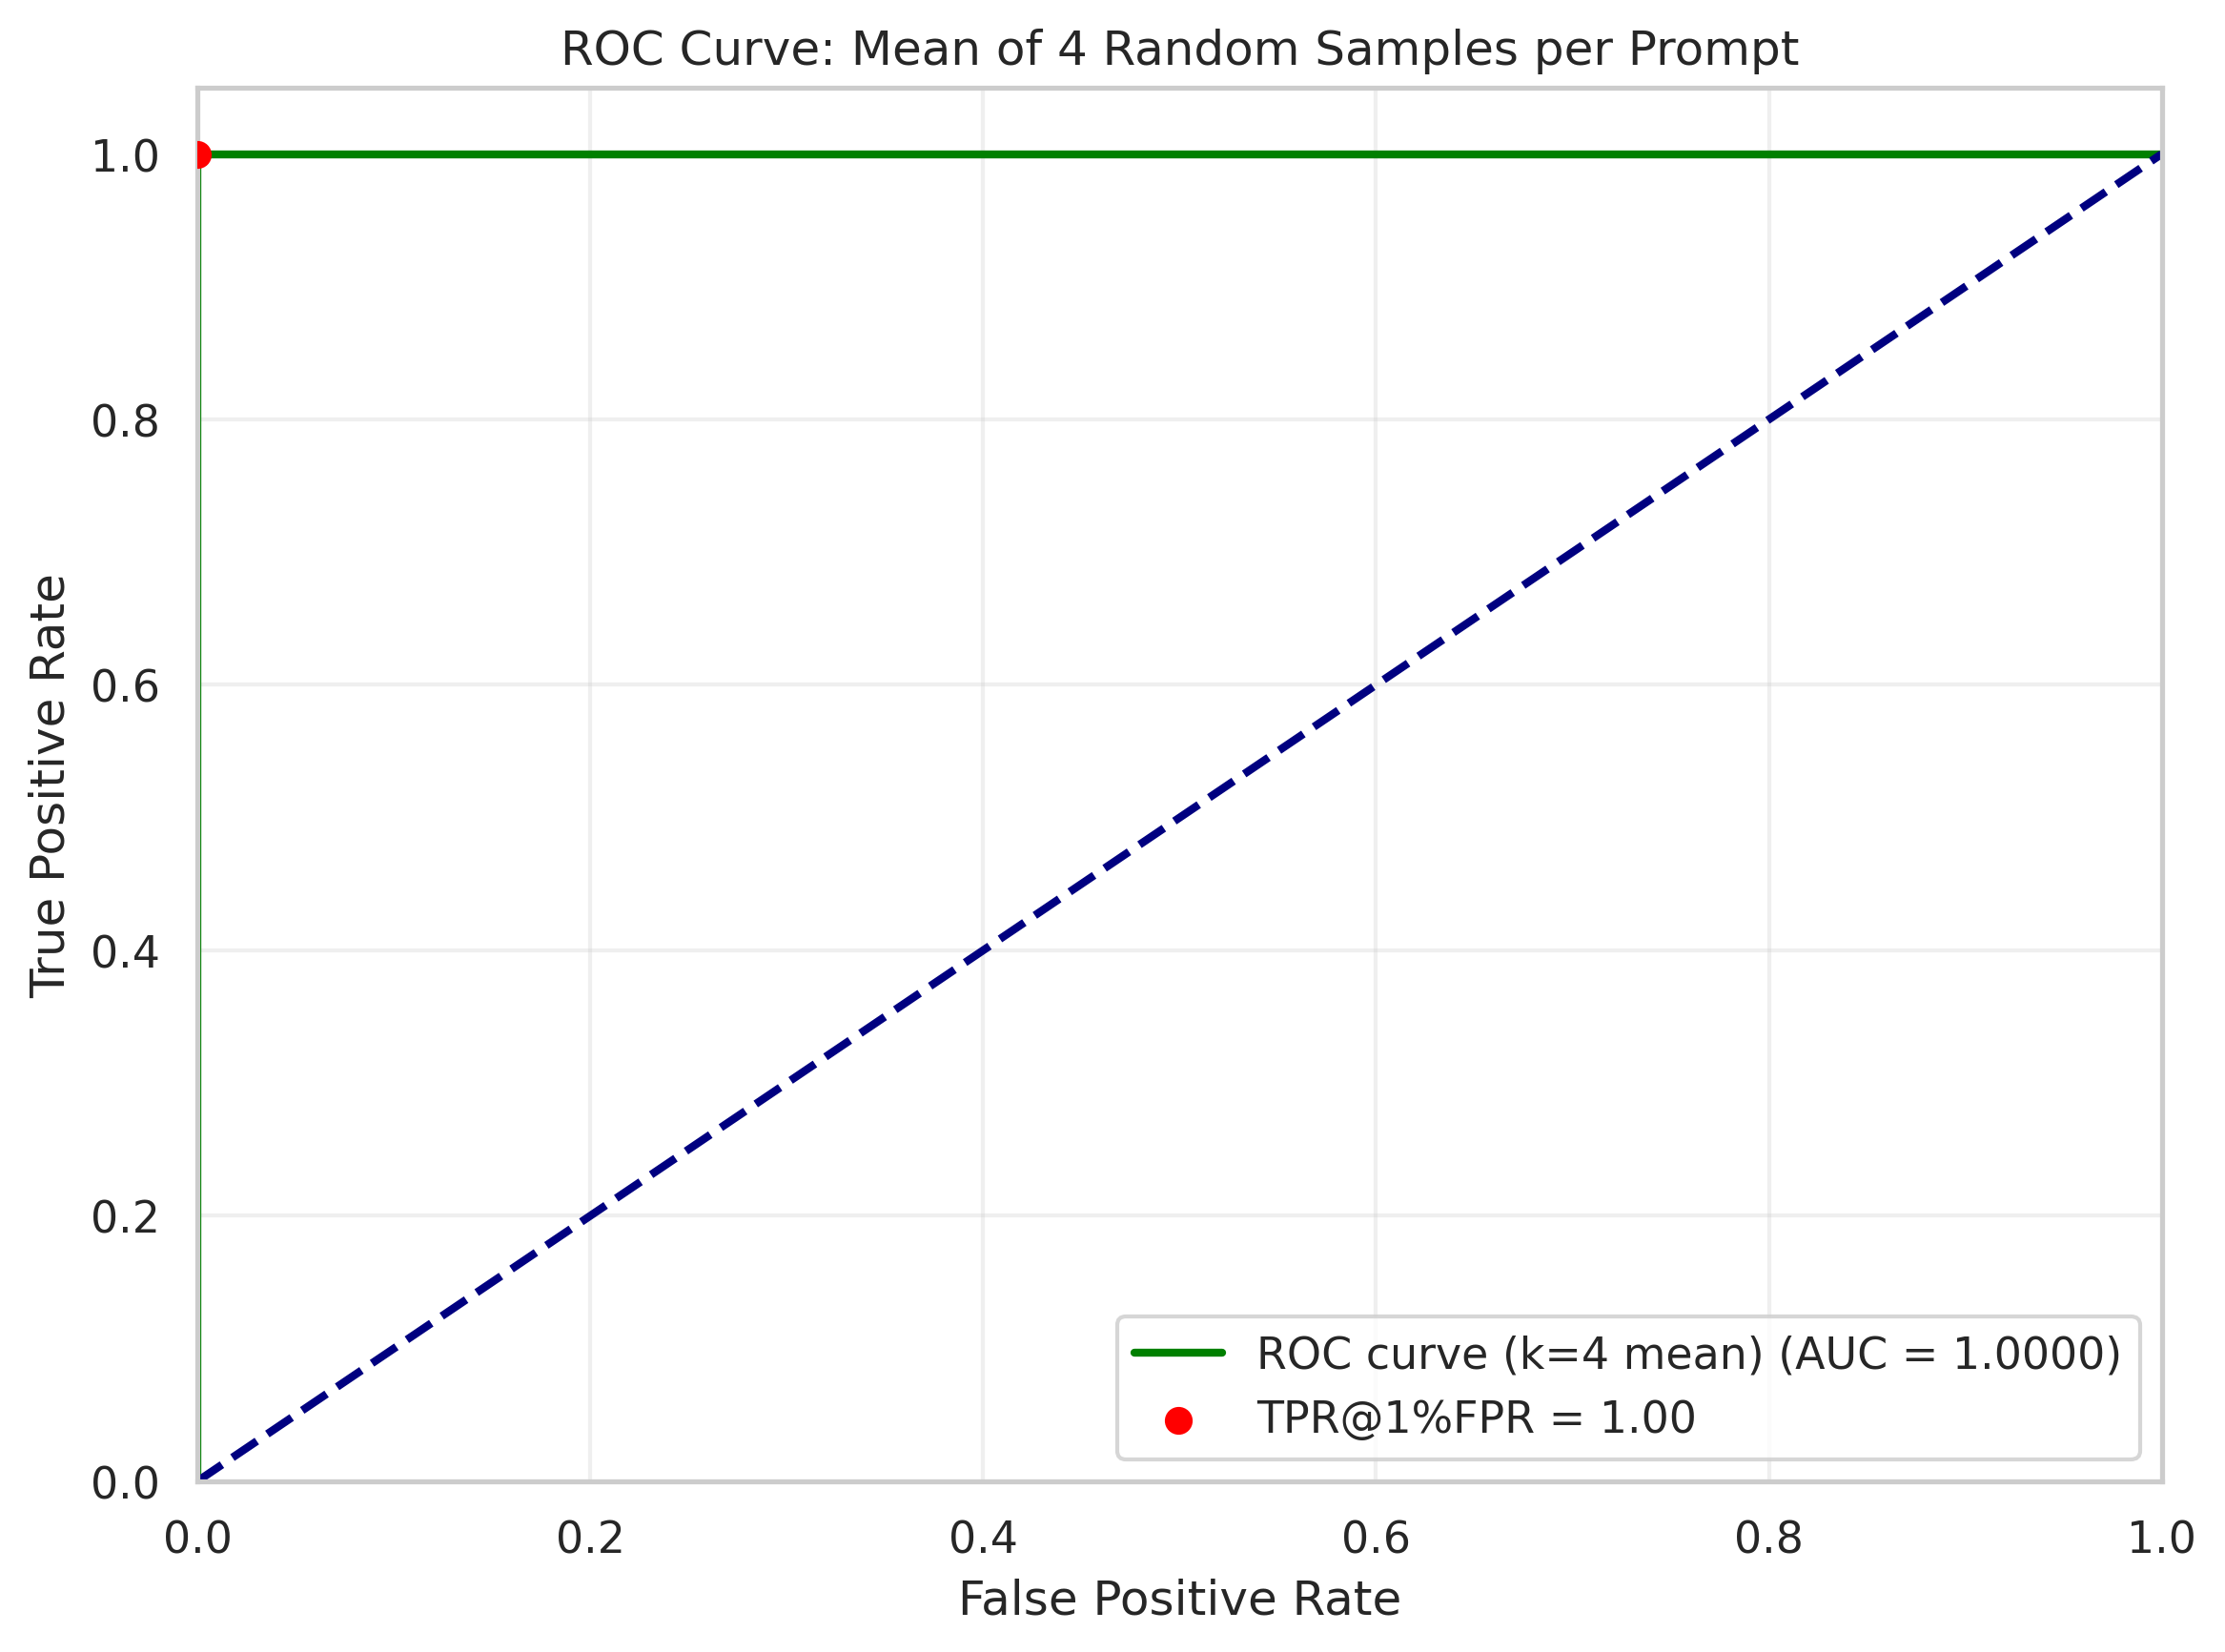

In [11]:

# --- ROC Analysis for Subsampling (k=4) ---
print("\nPerforming ROC Analysis on Random Subsampling (k=4)...")

# Group by Prompt (to ensure we sample from same prompt)
grouped = df_results.groupby(["Group", "Caption"])["JacobianNorm"].apply(lambda x: np.array(x))

y_true_sub = []
y_scores_sub = []

num_trials = 5  # Number of random samplings per prompt to get more robust stats, or just 1? 
# User asked for "when 4 random samples are picked", implying a singular methodological step.
# Let's do 1 trial per prompt to simulate "if we only took 4 samples".

np.random.seed(42) # Reproducibility

for (group, caption), norms in grouped.items():
    if len(norms) >= 4:
        # Randomly select 4 samples
        selected_norms = np.random.choice(norms, size=4, replace=False)
        mean_val = np.mean(selected_norms)
        
        y_true_sub.append(1 if group == "Memorized" else 0)
        y_scores_sub.append(mean_val)

y_true_sub = np.array(y_true_sub)
y_scores_sub = np.array(y_scores_sub)

# Calculate ROC and AUC
fpr_sub, tpr_sub, thresholds_sub = roc_curve(y_true_sub, y_scores_sub)
roc_auc_sub = auc(fpr_sub, tpr_sub)

# Check directionality
if roc_auc_sub < 0.5:
    y_scores_sub = -y_scores_sub
    fpr_sub, tpr_sub, thresholds_sub = roc_curve(y_true_sub, y_scores_sub)
    roc_auc_sub = auc(fpr_sub, tpr_sub)

# Calculate TPR at 1% FPR
valid_indices_sub = np.where(fpr_sub <= 0.01)[0]
if len(valid_indices_sub) > 0:
    idx_1pct_sub = valid_indices_sub[-1]
    tpr_at_1pct_fpr_sub = tpr_sub[idx_1pct_sub]
    actual_fpr_sub = fpr_sub[idx_1pct_sub]
else:
    tpr_at_1pct_fpr_sub = 0.0
    actual_fpr_sub = 0.0

print(f"Subsampling (k=4) ROC Results:")
print(f"AUC: {roc_auc_sub:.4f}")
print(f"TPR at 1% FPR: {tpr_at_1pct_fpr_sub:.4f} (at FPR={actual_fpr_sub:.4f})")

# Plot ROC Curve
plt.figure(figsize=(8, 6), dpi=300)
plt.plot(fpr_sub, tpr_sub, color='green', lw=2, label=f'ROC curve (k=4 mean) (AUC = {roc_auc_sub:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(actual_fpr_sub, tpr_at_1pct_fpr_sub, color='red', zorder=5, label=f'TPR@1%FPR = {tpr_at_1pct_fpr_sub:.2f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Mean of 4 Random Samples per Prompt')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("jacobian_classification_subsample_k4_roc.png")
plt.show()



Performing ROC Analysis on 25 Non-Overlapping Groups of 4 Samples per Prompt...
25-Fold Subsampling (k=4) ROC Results (Treating each fold as independent):
AUC: 0.9862
TPR at 1% FPR: 0.9320 (at FPR=0.0040)


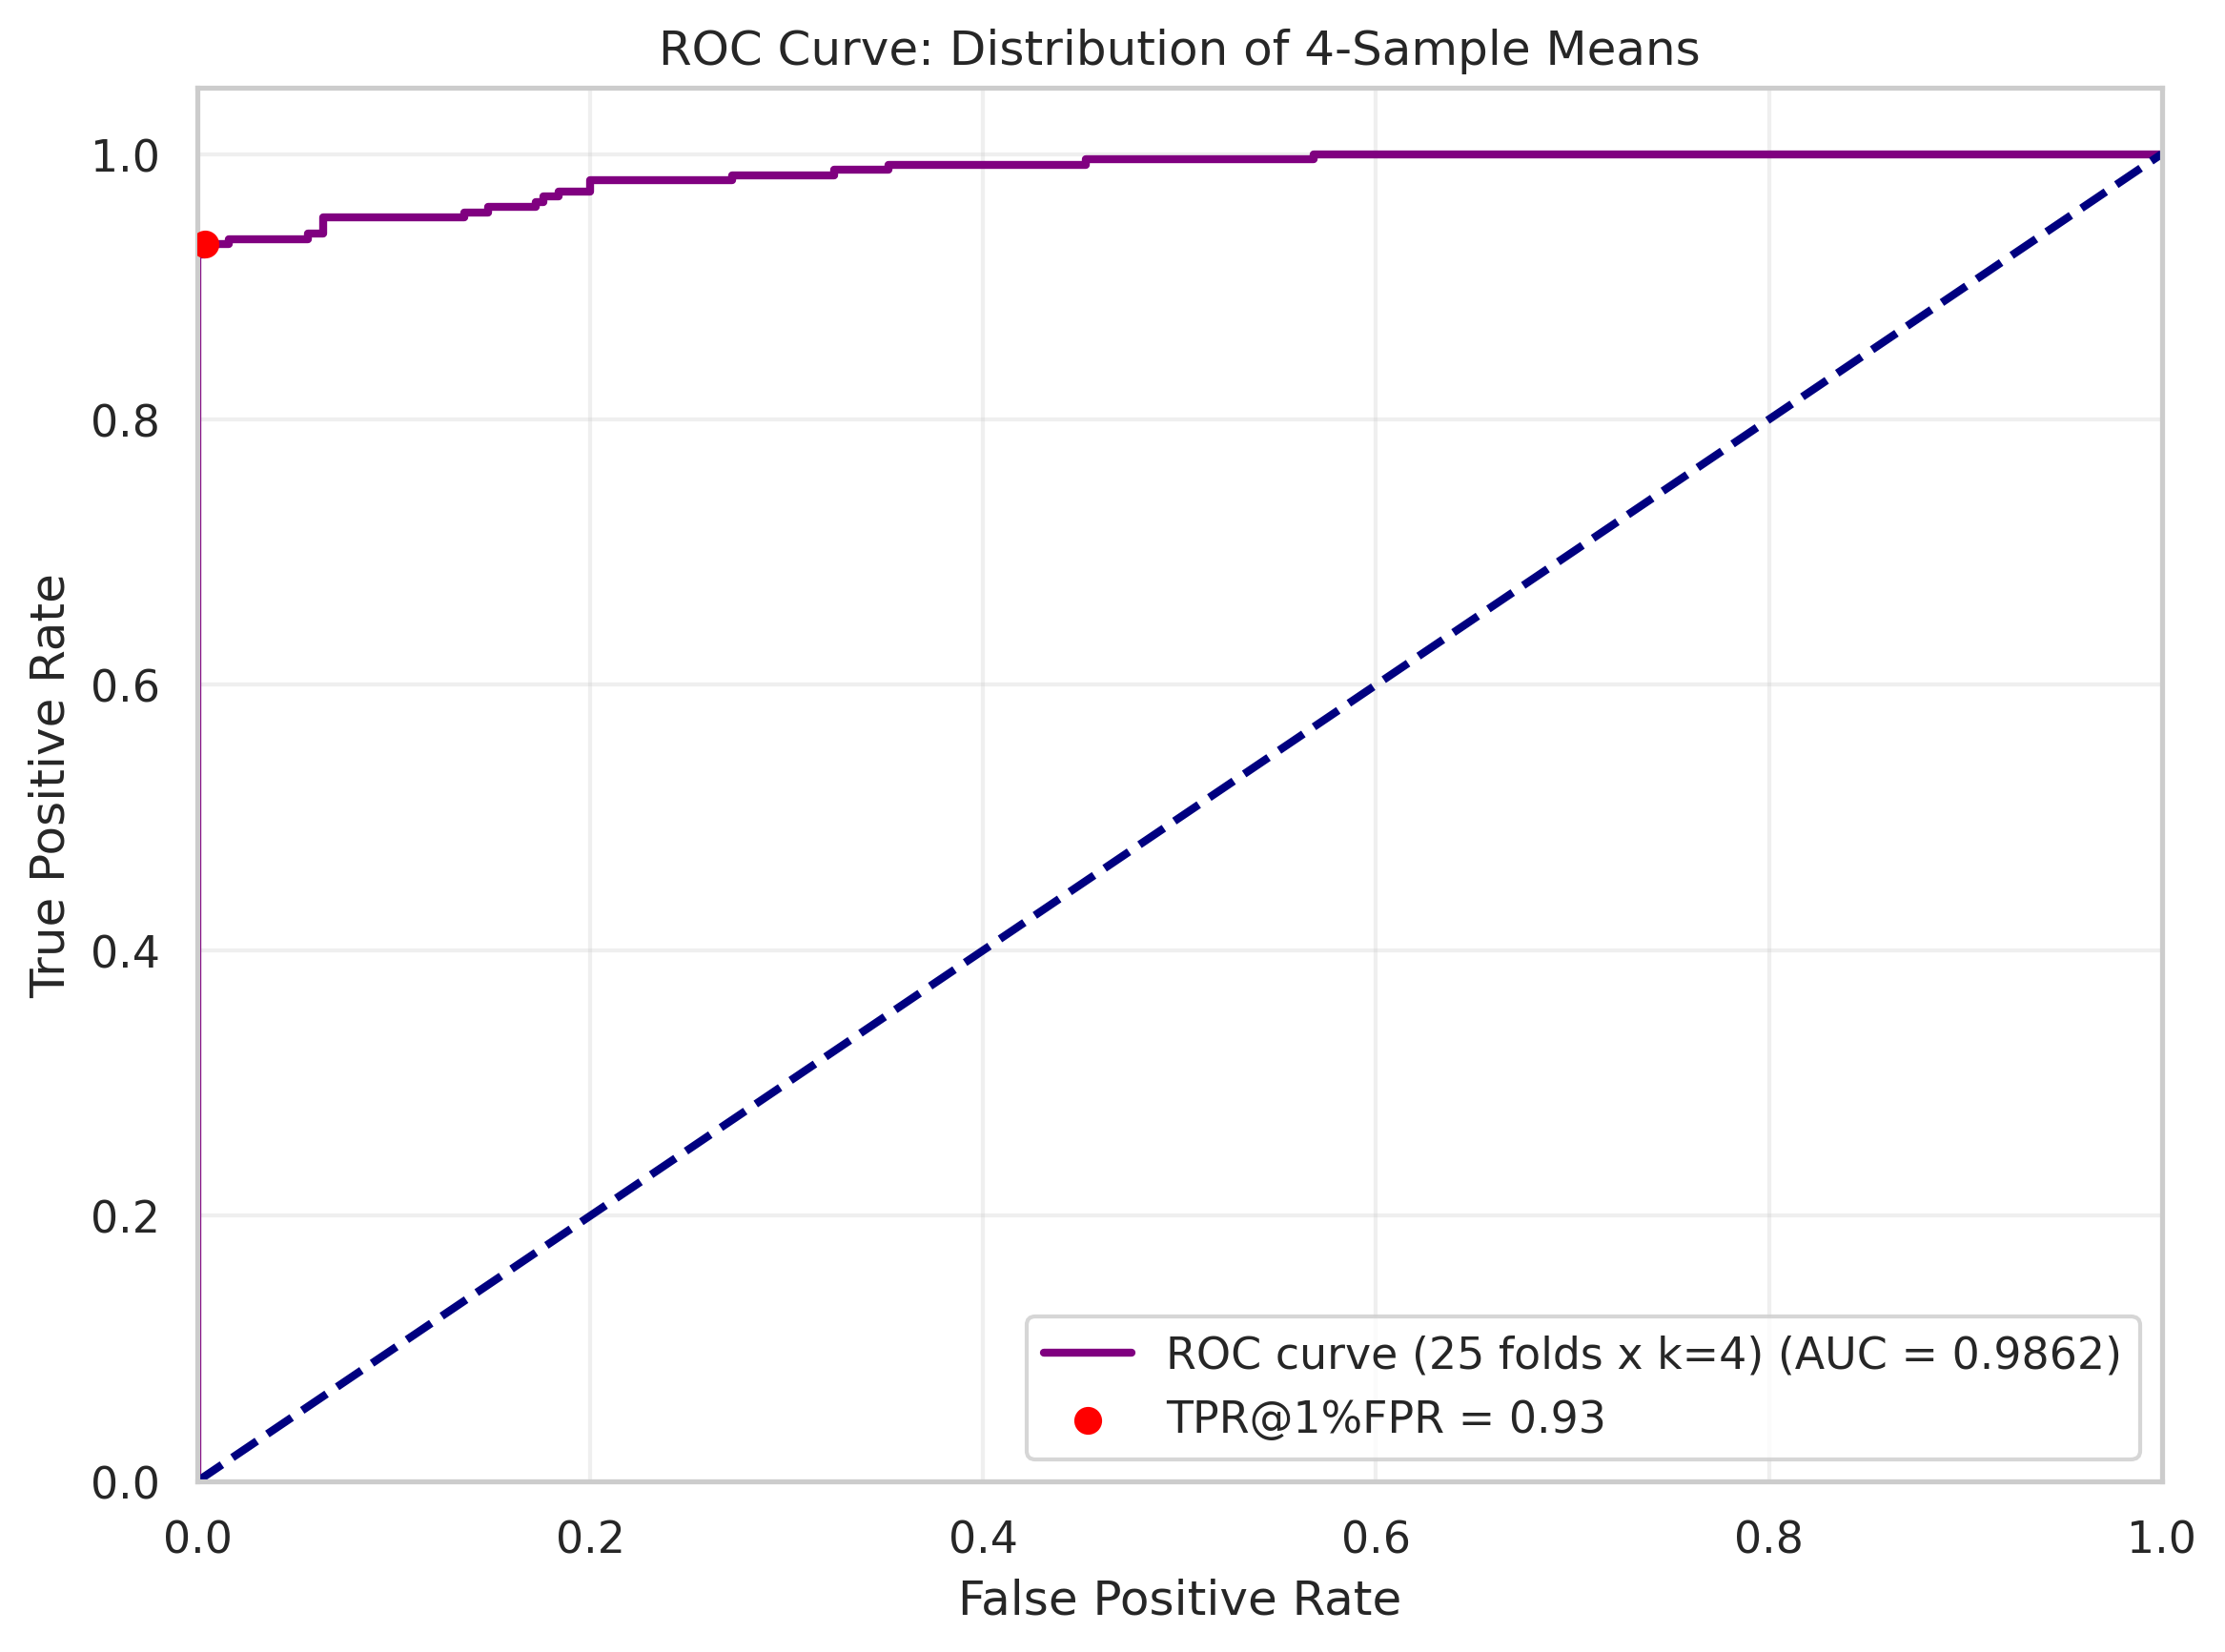


--- 25 Group Means & Grand Mean (Showing first 5 prompts) ---
Prompt: """Green Sea Horse"" Beach Hou... (Memorized)
  Grand Mean: 6.7475
  25 Group Means (k=4): [ 6.425  7.146  7.236  6.899 14.892  4.558  6.732  6.121  5.257  8.192
  3.108  8.556  5.243 11.665  5.367  4.14   8.264  3.2    7.791  4.669
  4.394  7.324  7.649  4.531  9.329]
--------------------------------------------------
Prompt: 24B613S12 | Medium Natural Ash... (Memorized)
  Grand Mean: 1.8891
  25 Group Means (k=4): [1.826 1.852 1.62  1.803 1.926 2.382 1.899 1.781 2.205 1.676 1.81  1.812
 1.675 2.234 1.783 2.024 1.487 1.907 1.943 1.726 1.96  1.569 1.684 2.062
 2.581]
--------------------------------------------------
Prompt: 30A27S4 - Shaded Peach  - Brow... (Memorized)
  Grand Mean: 2.6567
  25 Group Means (k=4): [2.267 2.805 2.594 2.783 1.974 2.614 2.796 3.047 3.128 2.419 3.422 3.173
 3.088 2.766 2.18  2.904 3.082 1.807 1.99  2.533 3.093 2.226 3.013 2.237
 2.474]
--------------------------------------------------


In [12]:

# --- ROC Analysis for Subsampling (25 groups of 4 non-overlapping) ---
print("\nPerforming ROC Analysis on 25 Non-Overlapping Groups of 4 Samples per Prompt...")

from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Group by Prompt
grouped = df_results.groupby(["Group", "Caption"])["JacobianNorm"].apply(lambda x: np.array(x))

y_true_all_groups = []
y_scores_all_groups = []

# To store results for display (25 values per prompt)
results_display = []

np.random.seed(42)

for (group, caption), norms in grouped.items():
    if len(norms) >= 100: # Need at least 100 samples
        # Shuffle to ensure randomness, then split into 25 chunks of 4
        shuffled_norms = np.random.permutation(norms)[:100]
        chunks = np.array_split(shuffled_norms, 25)
        
        prompt_means = []
        for chunk in chunks:
            mean_val = np.mean(chunk)
            prompt_means.append(mean_val)
        
        # MOVED OUTSIDE THE LOOP
        y_true_all_groups.extend([1 if group == "Memorized" else 0] * 25)
        y_scores_all_groups.extend(prompt_means)
        
        # Store for display (example: first few prompts)
        if len(results_display) < 5:
             results_display.append({
                "Prompt": caption[:30] + "...",
                "Group": group,
                "25_Means": prompt_means,
                "Grand_Mean": np.mean(prompt_means)
            })

y_true_all_groups = np.array(y_true_all_groups)
y_scores_all_groups = np.array(y_scores_all_groups)

# Calculate ROC and AUC (aggregating all 25 trials per prompt)
fpr_25, tpr_25, thresholds_25 = roc_curve(y_true_all_groups, y_scores_all_groups)
roc_auc_25 = auc(fpr_25, tpr_25)

# Check directionality
if roc_auc_25 < 0.5:
    y_scores_all_groups = -y_scores_all_groups
    fpr_25, tpr_25, thresholds_25 = roc_curve(y_true_all_groups, y_scores_all_groups)
    roc_auc_25 = auc(fpr_25, tpr_25)

# Calculate TPR at 1% FPR
valid_indices_25 = np.where(fpr_25 <= 0.01)[0]
if len(valid_indices_25) > 0:
    idx_1pct_25 = valid_indices_25[-1]
    tpr_at_1pct_fpr_25 = tpr_25[idx_1pct_25]
    actual_fpr_25 = fpr_25[idx_1pct_25]
else:
    tpr_at_1pct_fpr_25 = 0.0
    actual_fpr_25 = 0.0

print(f"25-Fold Subsampling (k=4) ROC Results (Treating each fold as independent):")
print(f"AUC: {roc_auc_25:.4f}")
print(f"TPR at 1% FPR: {tpr_at_1pct_fpr_25:.4f} (at FPR={actual_fpr_25:.4f})")

# Plot ROC Curve
plt.figure(figsize=(8, 6), dpi=300)
plt.plot(fpr_25, tpr_25, color='purple', lw=2, label=f'ROC curve (25 folds x k=4) (AUC = {roc_auc_25:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(actual_fpr_25, tpr_at_1pct_fpr_25, color='red', zorder=5, label=f'TPR@1%FPR = {tpr_at_1pct_fpr_25:.2f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Distribution of 4-Sample Means')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("jacobian_classification_subsample_25folds_roc.png")
plt.show()

# Display Values
print("\n--- 25 Group Means & Grand Mean (Showing first 5 prompts) ---")
for i, res in enumerate(results_display):
    print(f"Prompt: {res['Prompt']} ({res['Group']})")
    print(f"  Grand Mean: {res['Grand_Mean']:.4f}")
    print(f"  25 Group Means (k=4): {np.round(res['25_Means'], 3)}")
    print("-" * 50)
